# Lab 04: fitting probability distributions to your data using `scipy.stats`
CCNY EAS 42000/A42000, Fall 2025, 2025/10/15, Prof. Spencer Hill

**SUMMARY**: We use `xarray` to load the `netCDF` file containing the Central Park weather station daily data from disk, and then a combination of `xarray` and `scipy` to fit parametric probability distributions to the data.

# Preliminaries

## Import needed python packages

In [1]:
from matplotlib import pyplot as plt  # for plotting
import numpy as np # for working with arrays of numerical values
import scipy  # for fitting PDFs
import xarray as xr  # for loading data and subsequent analyses

## Load the Central Park data into this python session

:::{admonition} Explanation of data downloading logic (if you're interested)
:class: dropdown
To make these Jupyter notebooks work when launched to Google Colab---which you can do by clicking the "rocket" icon in the top right from the rendered version of this page on the web---we need some logic that downloads the data.

While we're at it, we use the file's "hash" to check that it has not been altered or corrupted from its original version.  We do this whether or not you've downloaded the file, since it's possible to (accidentally) modify the netCDF file on disk after you downloaded it.

In the rendered HTML version of the site, this cell is hidden, since otherwise it's a bit distracting.  But you can click on it to reveal its content.

If you're in a Google Colab session, you don't need to modify anything in that cell; just run it.  Otherwise, modify the `LOCAL_DATA_DIR` variable defined in the next python cell to point to where the dataset lives on your machine---or where you want it to be downloaded to if you don't have it already.
:::

In [2]:
!pip install pooch

# The above command installs the needed `pooch` 3rd-party package if it's not already installed.


import hashlib  # for verifying that the Central Park file is not corrupted
import pathlib  # for constructing paths to the dataset's location on disk
import sys  # for checking if this is a Google Colab session or not
import pooch  # for downloading the dataset from the web, if needed


# Replace "../data" as needed to point to the correct directory for you.
# This can be an *absolute path* or a *relative path*.  One dot, `.`, means
# "this directory", while two dots, `..`, means "go up one directory."
LOCAL_DATA_DIR = "../data"  # If you're in Colab: just ignore this.

# The URL where the dataset can be downloaded from.
DATA_URL = (
    "https://spencerahill.github.io/25f-stat-methods-course/_downloads/"
    "91803b82950d49961a65355c075439b3/central-park-station-data_1869-01-01_2023-09-30.nc"
)

# This HASH_HEX stores a "hash" which we use to verify that the data you end up
# with has not been altered or corrupted compared to the one at the above URL.
HASH_HEX = "85237a4bae1202030a36f330764fd5bd0c2c4fa484b3ae34a05db49fe7721eee"


def create_data_path(
    colab_dir="/content/data", 
    local_dir=LOCAL_DATA_DIR,
    filename="central-park-station-data_1869-01-01_2023-09-30.nc",
):
    """Set the path for the data, whether on colab or a local Jupyter session."""
    is_this_a_colab = "google.colab" in sys.modules
    if is_this_a_colab:
        data_dir = colab_dir 
    else: 
        data_dir = local_dir

    DATA_DIR = pathlib.Path(data_dir)
    DATA_DIR.mkdir(parents=True, exist_ok=True)
    return DATA_DIR / filename


def sha256sum(path: pathlib.Path) -> str:
    """Get the hash of the file at the specified path."""
    return hashlib.sha256(path.read_bytes()).hexdigest()


DATA_PATH = create_data_path()
# Determine if we'll need to download the data, which we'll do if either (a) 
# the data can't be found, or (b) it appears corrupted/modified from the
# "master" file at the above URL.
need_fetch = (not DATA_PATH.exists()) or (sha256sum(DATA_PATH) != HASH_HEX)

# Download the data if needed.
if need_fetch:
    fetched_data = pooch.retrieve(
        url=DATA_URL, 
        known_hash=f"sha256:{HASH_HEX}",
        path=DATA_PATH.parents[0], 
        fname=DATA_PATH.name,
    )
    print(f"\nDownloaded and verified: {fetched_data}")
else:
    print(f"\nVerified existing file at {DATA_PATH}")

Looking in links: https://pypi.python.org/pypi, https://testpypi.python.org/pypi

Verified existing file at ../data/central-park-station-data_1869-01-01_2023-09-30.nc


In [3]:
import xarray as xr

# `DATA_PATH` variable was created by the hidden cell just above. 
# Un-hide that cell if you want to see the details.
ds_cp = xr.open_dataset(DATA_PATH)
ds_cp

<xarray.Dataset> Size: 5MB
Dimensions:        (time: 56520)
Coordinates:
  * time           (time) datetime64[ns] 452kB 1869-01-01 ... 2023-09-30
Data variables:
    temp_max       (time) int64 452kB ...
    temp_min       (time) int64 452kB ...
    temp_avg       (time) float64 452kB ...
    temp_anom      (time) float64 452kB ...
    heat_deg_days  (time) int64 452kB ...
    cool_deg_days  (time) int64 452kB ...
    precip         (time) float64 452kB ...
    snow_fall      (time) float64 452kB ...
    snow_depth     (time) int64 452kB ...

# Fit a PDF to the Central Park data using `scipy.stats`

There are a ton of available distributions in `scipy.stats`.  You can see a complete list along with other useful information on the associated [docs page](https://docs.scipy.org/doc/scipy/reference/stats.html#probability-distributions).

We can also see them, along with everything else defined within `scipy.stats`, using the built-in `dir` function:

In [4]:
dir(scipy.stats)

['Binomial',
 'BootstrapMethod',
 'CensoredData',
 'ConstantInputWarning',
 'Covariance',
 'DegenerateDataWarning',
 'FitError',
 'Mixture',
 'MonteCarloMethod',
 'NearConstantInputWarning',
 'Normal',
 'PermutationMethod',
 'Uniform',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_ansari_swilk_statistics',
 '_axis_nan_policy',
 '_biasedurn',
 '_binned_statistic',
 '_binomtest',
 '_bws_test',
 '_censored_data',
 '_common',
 '_constants',
 '_continuous_distns',
 '_correlation',
 '_covariance',
 '_crosstab',
 '_discrete_distns',
 '_distn_infrastructure',
 '_distr_params',
 '_distribution_infrastructure',
 '_entropy',
 '_finite_differences',
 '_fit',
 '_hypotests',
 '_kde',
 '_ksstats',
 '_levy_stable',
 '_mannwhitneyu',
 '_mgc',
 '_morestats',
 '_mstats_basic',
 '_mstats_extras',
 '_multicomp',
 '_multivariate',
 '_new_distributions',
 '_odds_ratio',
 '_page_trend_test',
 '_probability_distribu

To start, let's use the normal function, which is `scipy.stats.norm`:

In [5]:
help(scipy.stats.norm)

Help on norm_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.norm_gen object>
    A normal continuous random variable.

    The location (``loc``) keyword specifies the mean.
    The scale (``scale``) keyword specifies the standard deviation.

    As an instance of the `rv_continuous` class, `norm` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.

    Methods
    -------
    rvs(loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, loc=0, scale=1)
        Probability density function.
    logpdf(x, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, loc=0, scale=1)
        Cumulative distribution function.
    logcdf(x, loc=0, scale=1)
        Log of the cumulative distribution function.
    sf(x, loc=0, scale=1)
        Survival function  (also defined as ``1 - cdf``, but `sf` is sometim

Let's start with daily minimum temperatures in the month of May:

In [6]:
temp_min_may = ds_cp["temp_min"].where(ds_cp["time"].dt.month == 5, drop=True)
temp_min_may

<xarray.DataArray 'temp_min' (time: 4805)> Size: 38kB
array([42.,  0.,  0., ..., 59., 55., 51.], shape=(4805,))
Coordinates:
  * time     (time) datetime64[ns] 38kB 1869-05-01 1869-05-02 ... 2023-05-31
Attributes:
    units:    degrees F

First let's plot it's histogram:

(array([0.00021907, 0.        , 0.        , 0.        , 0.00052029,
        0.01377403, 0.05561641, 0.0423079 , 0.01659456, 0.00254669]),
 array([ 0. ,  7.6, 15.2, 22.8, 30.4, 38. , 45.6, 53.2, 60.8, 68.4, 76. ]),
 <BarContainer object of 10 artists>)

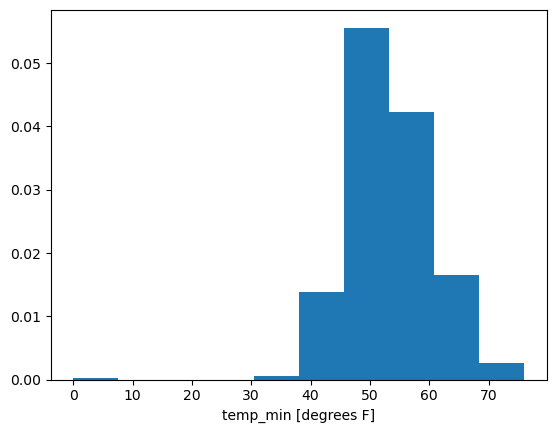

In [7]:
temp_min_may.plot.hist(density=True)
# could also use plt.hist(temp_min_may)

We see here the spurious 0 values.  So let's drop those:

In [8]:
temp_min_may = temp_min_may.where(temp_min_may != 0, drop=True)

Now we can try the histogram again:

(array([0.00028427, 0.00106601, 0.00369549, 0.01435556, 0.02949286,
        0.04704645, 0.06346296, 0.06140201, 0.04740179, 0.03176701,
        0.02025414, 0.01179715, 0.00575644, 0.00248735, 0.0006396 ]),
 array([32.        , 34.93333333, 37.86666667, 40.8       , 43.73333333,
        46.66666667, 49.6       , 52.53333333, 55.46666667, 58.4       ,
        61.33333333, 64.26666667, 67.2       , 70.13333333, 73.06666667,
        76.        ]),
 <BarContainer object of 15 artists>)

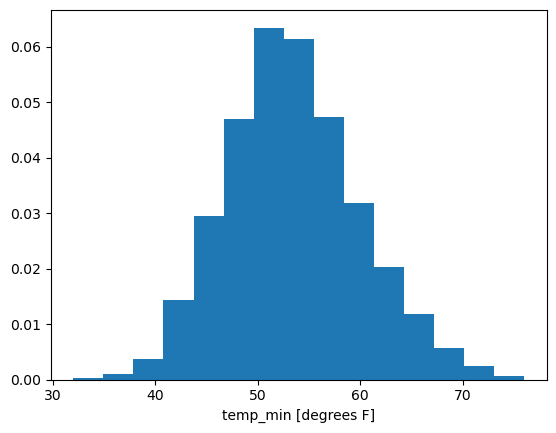

In [9]:
temp_min_may.plot.hist(density=True, bins=15)

That looks pretty normal---as in, pretty Gaussian---to me!

So let's proceed with **fitting** a normal distribution to the data.

To do so we use the `.fit` method of `scipy.stats.norm`.  You simply give it the data you want to fit as the sole argument, and it returns the best-fit values of both of the normal distribution's parameters: the mean $\mu$ and standard deviation $\sigma$.

In [10]:
mean, stdev = scipy.stats.norm.fit(temp_min_may)
mean, stdev

(np.float64(53.42172190952679), np.float64(6.63132999778397))

This means that the best-fit normal distribution for this data has a mean near 53.4$^\circ$F and a standard deviation near 6.6$^\circ$F

Now let's overlay this on the histogram to inspect by eye how well it performs.

First, we'll create a "frozen" normal PDF by specifying these values of the mean and standard deviation in a new call to `scipy.stats.norm`.

Note: the mean is called `loc`, and the standard deviation is called `scale`, because these are shared names across all distributions...different distributions have different parameters and names for them, and so scipy uses these "universal" names of `loc` and `scale` (along with others).

In [11]:
normal_for_tmin_may = scipy.stats.norm(loc=mean, scale=stdev)
normal_for_tmin_may

Now we can call this object's `pdf` method, giving it any point or points we want to know the PDF value at:

In [12]:
print(normal_for_tmin_may.pdf(50))  # the value of this PDF at 50 deg F
print(normal_for_tmin_may.pdf([40, 100]))  # the PDF's value at the two points 40 deg F and 100 deg F

0.05266161442811993
[7.75820374e-03 1.16437434e-12]


What we want to do is visually inspect how this PDF compares to our histogram above across the whole range of values.

To do that, we'll compute the PDF at a whole bunch of individual values spanning that range, and then plot the line connecting all those individual values.

To do so, we'll create the array of x values over which the values of this distribution's PDF will be plotted.

To do this we'll make use of numpy's `linspace` function, which creates an array of equally spaced points between two specified endpoints:

In [13]:
help(np.linspace)

Help on _ArrayFunctionDispatcher in module numpy:

linspace(
    start,
    stop,
    num=50,
    endpoint=True,
    retstep=False,
    dtype=None,
    axis=0,
    *,
    device=None
)
    Return evenly spaced numbers over a specified interval.

    Returns `num` evenly spaced samples, calculated over the
    interval [`start`, `stop`].

    The endpoint of the interval can optionally be excluded.

    .. versionchanged:: 1.20.0
        Values are rounded towards ``-inf`` instead of ``0`` when an
        integer ``dtype`` is specified. The old behavior can
        still be obtained with ``np.linspace(start, stop, num).astype(int)``

    Parameters
    ----------
    start : array_like
        The starting value of the sequence.
    stop : array_like
        The end value of the sequence, unless `endpoint` is set to False.
        In that case, the sequence consists of all but the last of ``num + 1``
        evenly spaced samples, so that `stop` is excluded.  Note that the step
        

In [14]:
xvals_for_norm_fit = np.linspace(temp_min_may.min().values, temp_min_may.max().values, 100)
xvals_for_norm_fit

array([32.        , 32.44444444, 32.88888889, 33.33333333, 33.77777778,
       34.22222222, 34.66666667, 35.11111111, 35.55555556, 36.        ,
       36.44444444, 36.88888889, 37.33333333, 37.77777778, 38.22222222,
       38.66666667, 39.11111111, 39.55555556, 40.        , 40.44444444,
       40.88888889, 41.33333333, 41.77777778, 42.22222222, 42.66666667,
       43.11111111, 43.55555556, 44.        , 44.44444444, 44.88888889,
       45.33333333, 45.77777778, 46.22222222, 46.66666667, 47.11111111,
       47.55555556, 48.        , 48.44444444, 48.88888889, 49.33333333,
       49.77777778, 50.22222222, 50.66666667, 51.11111111, 51.55555556,
       52.        , 52.44444444, 52.88888889, 53.33333333, 53.77777778,
       54.22222222, 54.66666667, 55.11111111, 55.55555556, 56.        ,
       56.44444444, 56.88888889, 57.33333333, 57.77777778, 58.22222222,
       58.66666667, 59.11111111, 59.55555556, 60.        , 60.44444444,
       60.88888889, 61.33333333, 61.77777778, 62.22222222, 62.66

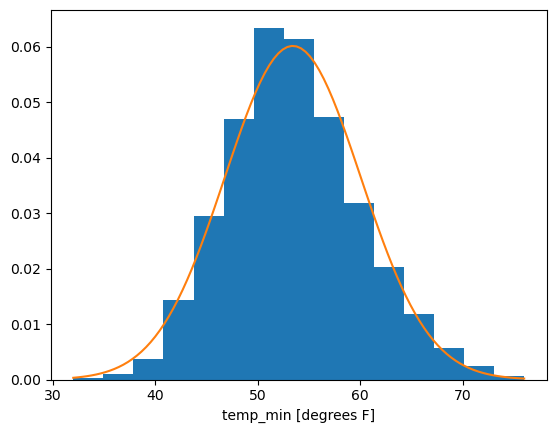

In [15]:
fig, ax = plt.subplots()

temp_min_may.plot.hist(ax=ax, density=True, bins=15)

plt.plot(xvals_for_norm_fit, normal_for_tmin_may.pdf(xvals_for_norm_fit))

Nice!  By visual inspection, this sample of daily minimum temperatures in the month of May for 1869-2023 looks pretty well approximated by a normal distribution!